# Basics of mobile robotics project - The Thytanic Navigation (2024)

## 1. Introduction & Context

| **Contributors**         | **Sciper**  | **Role**             | **Studies**                                                                   |
|---------------------------|-------------|-----------------------|---------------------------------------------------------------------------  |
| **Alessio Desogus**       | 301705      | Local Navigation      | Bachelor and Master in Mechanical Engineering                               |
|   **Antoine Bachmann**    |  336641     | Global navigation      | Bachelor and Master in Computer Science                                    |
|**Ramon Heeb**             |   396213    | Vision                | Bachelor in Computer Science, Master in Robotics                            |
| **Adélaïde Pinel**        |             |  Kalman Filtering                     |  Bachelor and Master in Mechanical Engineering              |

Date of deliverable: 05.12.2024  

Our main sources were: 
- .
- .

### Project Description

This project involves guiding the **Thytanic** from its starting position to its destination in an efficient manner using `Global Navigation`. Along the way, the Thytanic must avoid appearing obstacles by employing `Local Navigation`. Additionally, the position of the Thytanic is estimated using a `Kalman Filter`. Finally, a stationary camera is positioned above the map to provide `Vision` information for the system’s navigation modules.

Imagine the following scenario: the Thytanic is navigating in the vast ocean (**blue background**) and is seeking to reach land (**green area**) safely while avoiding dangerous icebergs (**white obstacles**). At the same time, it must avoid colliding with **black zones** representing dangerous land masses. Its goal is to navigate the shortest, most energy-efficient route to safety.


![Local Navigation Algorithm](img/thytanic.png)

- ref background: https://www.freepik.com/premium-ai-image/iceberg-water-with-icebergs-background_55113664.htm
- ref thymio: https://edu.ge.ch/site/desrobotsenclasse/wp-content/uploads/sites/269/2015/02/front.jpg


## 2. Initialization

In [7]:
from local_navigation_and_control_all import ThytanicController, ThytanicState
from vision import get_current_state, init_cam
from global_navigation import downsamplingprep, downsampling, pathfinder
from kalman_filtering_all import kalman_filter
import numpy as np, matplotlib.pyplot as plt
import time

In [8]:
# Initialize the ThytanicController
thytanic = ThytanicController()

## 3. Vision

In [9]:
#turn the image into a 4-channel map
cam = init_cam()
img, _, _ = get_current_state(
    cam=cam,
    obstacle_range=[np.array([0, 150, 25]), np.array([30, 220, 100])],
    target_range=[np.array([0, 30, 235]), np.array([255, 130, 256])],
    th_front_range=[np.array([0, 160, 250]), np.array([15, 250, 256])],
    th_back_range=[np.array([16, 130, 150]), np.array([35, 250, 249])],
)

## 4. Global Navigation


[]

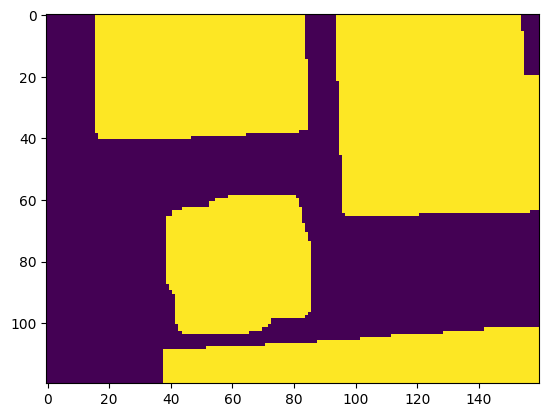

In [10]:
endsize = [120, 160]

#this line generates the original enposition, thymio position, and the obstacle channel
thymiopos, endpos, obstacleimage = downsamplingprep(img, endsize, 1, 1)

#this line turns obstacleimage into its downsampled version with enlarged obstacles
preppedimage = downsampling(obstacleimage, endsize, 20, 0.2)


plt.imshow(preppedimage)
plt.plot()

[]

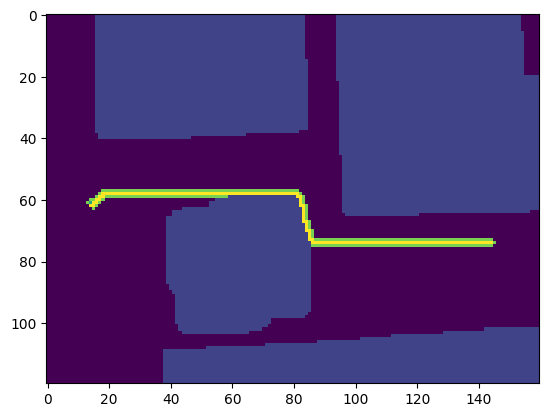

In [11]:
path, exploredpoints, unexploredpoints = pathfinder(thymiopos, endpos, preppedimage)

testimage = preppedimage.copy()

for k in path:
    testimage[k[0], k[1]] += 2
    
for k in exploredpoints:
    testimage[k[0], k[1]] += 3

for k in unexploredpoints:
    testimage[k[0], k[1]] += 4


plt.imshow(testimage)
plt.plot()

## 5. Kalman Filter

## 6. Local Navigation

![Local Navigation Algorithm](img/local_navigation.png)

## 7. Main Loop

Connecting to Thytanic...
Connection established!
initital_angle: -3.1808754426721584
Thytanic state set to GLOBAL_MOVEMENT.
accelerometer: 0
accelerometer: 0
accelerometer: 20
goal [134  74]
x 143.02266514257892 y 73.59245580515005 theta -3.212026644772576
goal index 0
delta_x -9.022665142578916 delta_y 0.4075441948499474
alpha 0.11557224750902195
v 70.42428281606503 omega 4.16060091032479
left speed 58.707842926709226
right speed 77.52960894960708
accelerometer: 0
accelerometer: 0
accelerometer: 20
goal [134  74]
x 143.03119944503447 y 73.67711796127732 theta -3.2270210662642422
goal index 0
delta_x -9.031199445034474 delta_y 0.32288203872268184
alpha 0.12116503630061759
v 70.44236405159984 omega 4.361941306822233
left speed 58.26991941543171
right speed 78.00251104153229
accelerometer: 0
accelerometer: 0
accelerometer: 20
goal [134  74]
x 142.4942086931568 y 73.55853826207903 theta -3.1788031956296177
goal index 0
delta_x -8.494208693156793 delta_y 0.44146173792097443
alpha 0.089135

c:\Users\ramon\anaconda3\envs\mob_rob\Lib\site-packages\numpy\lib\_function_base_impl.py:562: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\ramon\anaconda3\envs\mob_rob\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


accelerometer: -2
accelerometer: 12
accelerometer: 36
yay: 36
initital_angle: -1.4697906889298202
Thytanic state set to GLOBAL_MOVEMENT.
goal [80  8]
x 89.87250166222083 y 7.286761723670995 theta -1.4565497207410714
goal index 0
delta_x -9.872501662220827 delta_y 0.7132382763290046
alpha -1.6129232921942538
v 73.35539716395729 omega -58.065238518993134
left speed 202.29192069262172
right speed -60.384158321871006
accelerometer: 0
accelerometer: 0
accelerometer: 20
goal [80  8]
x 89.89561697655982 y 7.261112958765042 theta -1.4780523973169541
goal index 0
delta_x -9.895616976559822 delta_y 0.7388870412349577
alpha -1.5890104478375149
v 73.43589922148573 omega -57.204376122150535
left speed 200.42259851136095
right speed -58.35910299360579
accelerometer: 0
accelerometer: 0
accelerometer: 23
goal [80  8]
x 89.40703973533017 y 7.716886606289832 theta -1.6809636887968626
goal index 0
delta_x -9.407039735330173 delta_y 0.28311339371016775
alpha -1.4305421393771571
v 71.74115180259994 omega -

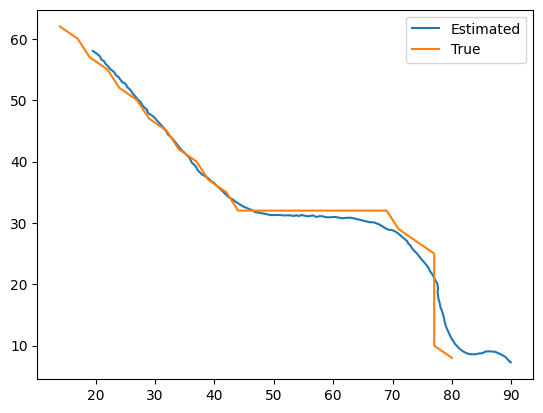

In [12]:
# Main script to establish connection and start movement
try:
    print("Connecting to Thytanic...")
    thytanic.establish_connection()
    print("Connection established!")
    _, thymiopos, initital_angle = get_current_state(    cam=cam,
    obstacle_range=[np.array([0, 150, 25]), np.array([30, 220, 100])],
    target_range=[np.array([0, 30, 235]), np.array([255, 130, 256])],
    th_front_range=[np.array([0, 160, 250]), np.array([15, 250, 256])],
    th_back_range=[np.array([16, 130, 150]), np.array([35, 250, 249])],)
    # Set the robot to GLOBAL_MOVEMENT state
    print("initital_angle:", initital_angle)
    thytanic.x_est = np.array([thymiopos[1], 0, thymiopos[0], 0,initital_angle,0]) #position, velocity (x,y,angle)
    thytanic.P_est = np.eye(6) # TO TUNE
    thytanic.goal_idx = 0
    thytanic.robot_state = ThytanicState.GLOBAL_MOVEMENT
    #thytanic.set_wheel_speed(100, 100)
    print("Thytanic state set to GLOBAL_MOVEMENT.")
    x_estimated = []
    ########################
    
    path = path[::5]
    path = path[2:]
    path = np.array([[p[1], p[0]] for p in path])
    ##########################
    # Start the robot movement loop
    while True:
        acc = thytanic.read_accelerometer()
        if(acc[2] > 25):
            print("yay:", acc[2])
            thytanic.set_wheel_speed(0, 0)
            time.sleep(20)
            img, _, _ = get_current_state(    cam=cam,
            obstacle_range=[np.array([0, 150, 25]), np.array([30, 220, 100])],
            target_range=[np.array([0, 30, 235]), np.array([255, 130, 256])],
            th_front_range=[np.array([0, 160, 250]), np.array([15, 250, 256])],
            th_back_range=[np.array([16, 130, 150]), np.array([35, 250, 249])],)
            endsize = [120, 160]

            #this line generates the original enposition, thymio position, and the obstacle channel
            thymiopos, endpos, obstacleimage = downsamplingprep(img, endsize, 1, 1)

            #this line turns obstacleimage into its downsampled version with enlarged obstacles
            preppedimage = downsampling(obstacleimage, endsize, 20, 0.2)
            path, exploredpoints, unexploredpoints = pathfinder(thymiopos, endpos, preppedimage)  
            _, thymiopos, initital_angle = get_current_state(    cam=cam,
            obstacle_range=[np.array([0, 150, 25]), np.array([30, 220, 100])],
            target_range=[np.array([0, 30, 235]), np.array([255, 130, 256])],
            th_front_range=[np.array([0, 160, 250]), np.array([15, 250, 256])],
            th_back_range=[np.array([16, 130, 150]), np.array([35, 250, 249])],)
            # Set the robot to GLOBAL_MOVEMENT state
            print("initital_angle:", initital_angle)
            thytanic.x_est = np.array([thymiopos[1], 0, thymiopos[0], 0,initital_angle,0]) #position, velocity (x,y,angle)
            thytanic.P_est = np.eye(6) # TO TUNE
            thytanic.goal_idx = 0
            thytanic.robot_state = ThytanicState.GLOBAL_MOVEMENT
            #thytanic.set_wheel_speed(100, 100)
            print("Thytanic state set to GLOBAL_MOVEMENT.")
            x_estimated = []
            ########################
            
            path = path[::5]
            path = path[2:]
            path = np.array([[p[1], p[0]] for p in path])  
        _, thymiopos, orientation = get_current_state(    cam=cam,
        obstacle_range=[np.array([0, 150, 25]), np.array([30, 220, 100])],
        target_range=[np.array([0, 30, 235]), np.array([255, 130, 256])],
        th_front_range=[np.array([0, 160, 250]), np.array([15, 250, 256])],
        th_back_range=[np.array([16, 130, 150]), np.array([35, 250, 249])],)
        # apply kalman filter and get the estimated positions thytanic.x_est
        kalman_filter(thytanic, [thymiopos[1], thymiopos[0], orientation])
        x_estimated.append(thytanic.x_est)
        #print("x_est", thytanic.x_est)
        thytanic.goal = path[thytanic.goal_idx] # get the (x,y) coordinates of the goal point
        print("goal", thytanic.goal)
        #print("goal_idx", thytanic.goal_idx)
        thytanic.update_robot_state()

        # Print the proximity sensor values
        sensor_values = thytanic.read_proximity_sensors()
        #print("Proximity sensor readings -- threshold of 2000 for detection:", sensor_values)
        
        if thytanic.goal_idx >= len(path):
            thytanic.robot_state = ThytanicState.STOP
            thytanic.update_robot_state()
            print("Goal reached!")
            break 

except KeyboardInterrupt:
    # Handle interruption and stop the robot safely
    print("\nStopping the Thytanic...")
    thytanic.disconnect()
    print("Thytanic stopped and disconnected.")

finally:
    print("Session ended.")
    plt.figure()
    plt.plot(np.array(x_estimated)[:,0], np.array(x_estimated)[:,2], label='Estimated')
    plt.plot(path[:,0], path[:,1], label='True')
    # Plot the path
    plt.legend()
    thytanic.disconnect()

## 9. Conclusion